In [74]:
from pathlib import Path
import re

import math
import scope
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

sns.set_theme(style="whitegrid", font_scale=1.2, palette="Paired")
plt.rcParams['figure.dpi'] = 300

In [85]:
def _read_float_file(path: Path, cutoff=200, min_length=None):
    reader = scope.Reader(path)
    steps, episode_scores = reader['episode/score']
    if min_length is not None:
        actual_steps = [steps[i] - (steps[i-1] if i > 0 else 0) for i in range(len(steps))]
        episode_scores = [score for i, score in enumerate(episode_scores) if actual_steps[i] >= min_length]
    
    if len(episode_scores) < cutoff:
        print(f"Warning: {path} has only {len(episode_scores)} episodes, less than the cutoff of {cutoff}.")
    return np.asarray(episode_scores)[:cutoff]


def plot_maniskill(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))
    rew_rand = _read_float_file(Path('./logdir/PICK_YCB/random/')).mean()
    print(f"Random reward: {rew_rand}")
    rew_max = 4 * 49 + 6 

    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path)).mean()
        norm_reward = (reward - rew_rand) / (rew_max - rew_rand)
        *model, dist = label.split(" ")
        dist = dist.replace("_", " ")
        data.append({
            'reward': norm_reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    my_palette = {
        "In-Distribution":   "#4AAD53",   # a green
        "Out-Of-Distribution": "#6699CC",   # an orange
        "Out-Of-Distribution Texture": "#FF3C1C"    # a blue
    }

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette=my_palette,
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(126, 200, 133),(133, 173, 214),(255, 155, 153)]
    for i, bar in enumerate(ax.patches):
        j = math.floor(i / n_models)
        if j >= len(baseline_rgb):
            continue

        if i % n_models == 0:
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb[j]), orig[3]))

        else:
            if i % n_models > 3:
                bar.set_hatch('..')


    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 200 episodes and 3 seeds in ManiSkill")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

def plot_carla(files_labels=[], output=None):
    plt.figure(figsize=(20, 6))
    rew_rand = _read_float_file(Path('./logdir/CARLA/random/')).mean()
    print(f"Random reward: {rew_rand}")
    rew_max = 1000 * (1 + 1.78)

    data = []
    for path, label in files_labels:
        reward = _read_float_file(Path(path), cutoff=50, min_length=21).mean()
        norm_reward = (reward - rew_rand) / (rew_max - rew_rand)
        *model, dist = label.split(" ")
        dist = dist.replace("_", " ")
        data.append({
            'reward': norm_reward,
            'model': " ".join(model),
            'Evaluation Distribution': dist,
        })
    print(data)
    df = pd.DataFrame(data)

    my_palette = {
        "In-Distribution":   "#4AAD53",   # a green
        "Out-Of-Distribution Weak": "#6699CC",   # an orange
        "Out-Of-Distribution Strong": "#FF3C1C"    # a blue
    }

    g = sns.catplot(
        data=df, 
        kind="bar", 
        x="model", 
        y="reward", 
        hue="Evaluation Distribution",
        errorbar="se", 
        alpha=0.8, 
        height=6, 
        aspect=2.5,
        palette=my_palette,
    )
    g.despine(left=True)

    ax = g.ax  # grab the single Axes
    n_models = df['model'].nunique()

    baseline_rgb = [(126, 200, 133),(133, 173, 214),(255, 155, 153)]
    for i, bar in enumerate(ax.patches):
        j = math.floor(i / n_models)
        if j >= len(baseline_rgb):
            continue

        if i % n_models == 0:
            orig = bar.get_facecolor()
            bar.set_facecolor((*(v/255.0 for  v in baseline_rgb[j]), orig[3]))

        else:
            if i % n_models > 3:
                bar.set_hatch('..')


    plt.xlabel("Vision Model")
    plt.ylabel("Average Returns")
    plt.title(f"Average returns over 50 episodes and 3 seeds in CARLA")
    # plt.tight_layout()
    if output:
        plt.savefig(output, dpi=300)
        print(f"Saved figure → {output}")

    average_rewards = df.groupby(['model', 'Evaluation Distribution'])['reward'].mean().reset_index()
    print(average_rewards)

Random reward: 0.6872856302400759
[{'reward': 0.05078601028717795, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.04918613916398696, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.05027608115400429, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.0489865621812314, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': 0.04932360952785731, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': 0.05079944858648631, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution'}, {'reward': -0.0028824559446209404, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward': -0.0026814688960969065, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward': -0.0027904699405792376, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Texture'}, {'reward'

<Figure size 6000x1800 with 0 Axes>

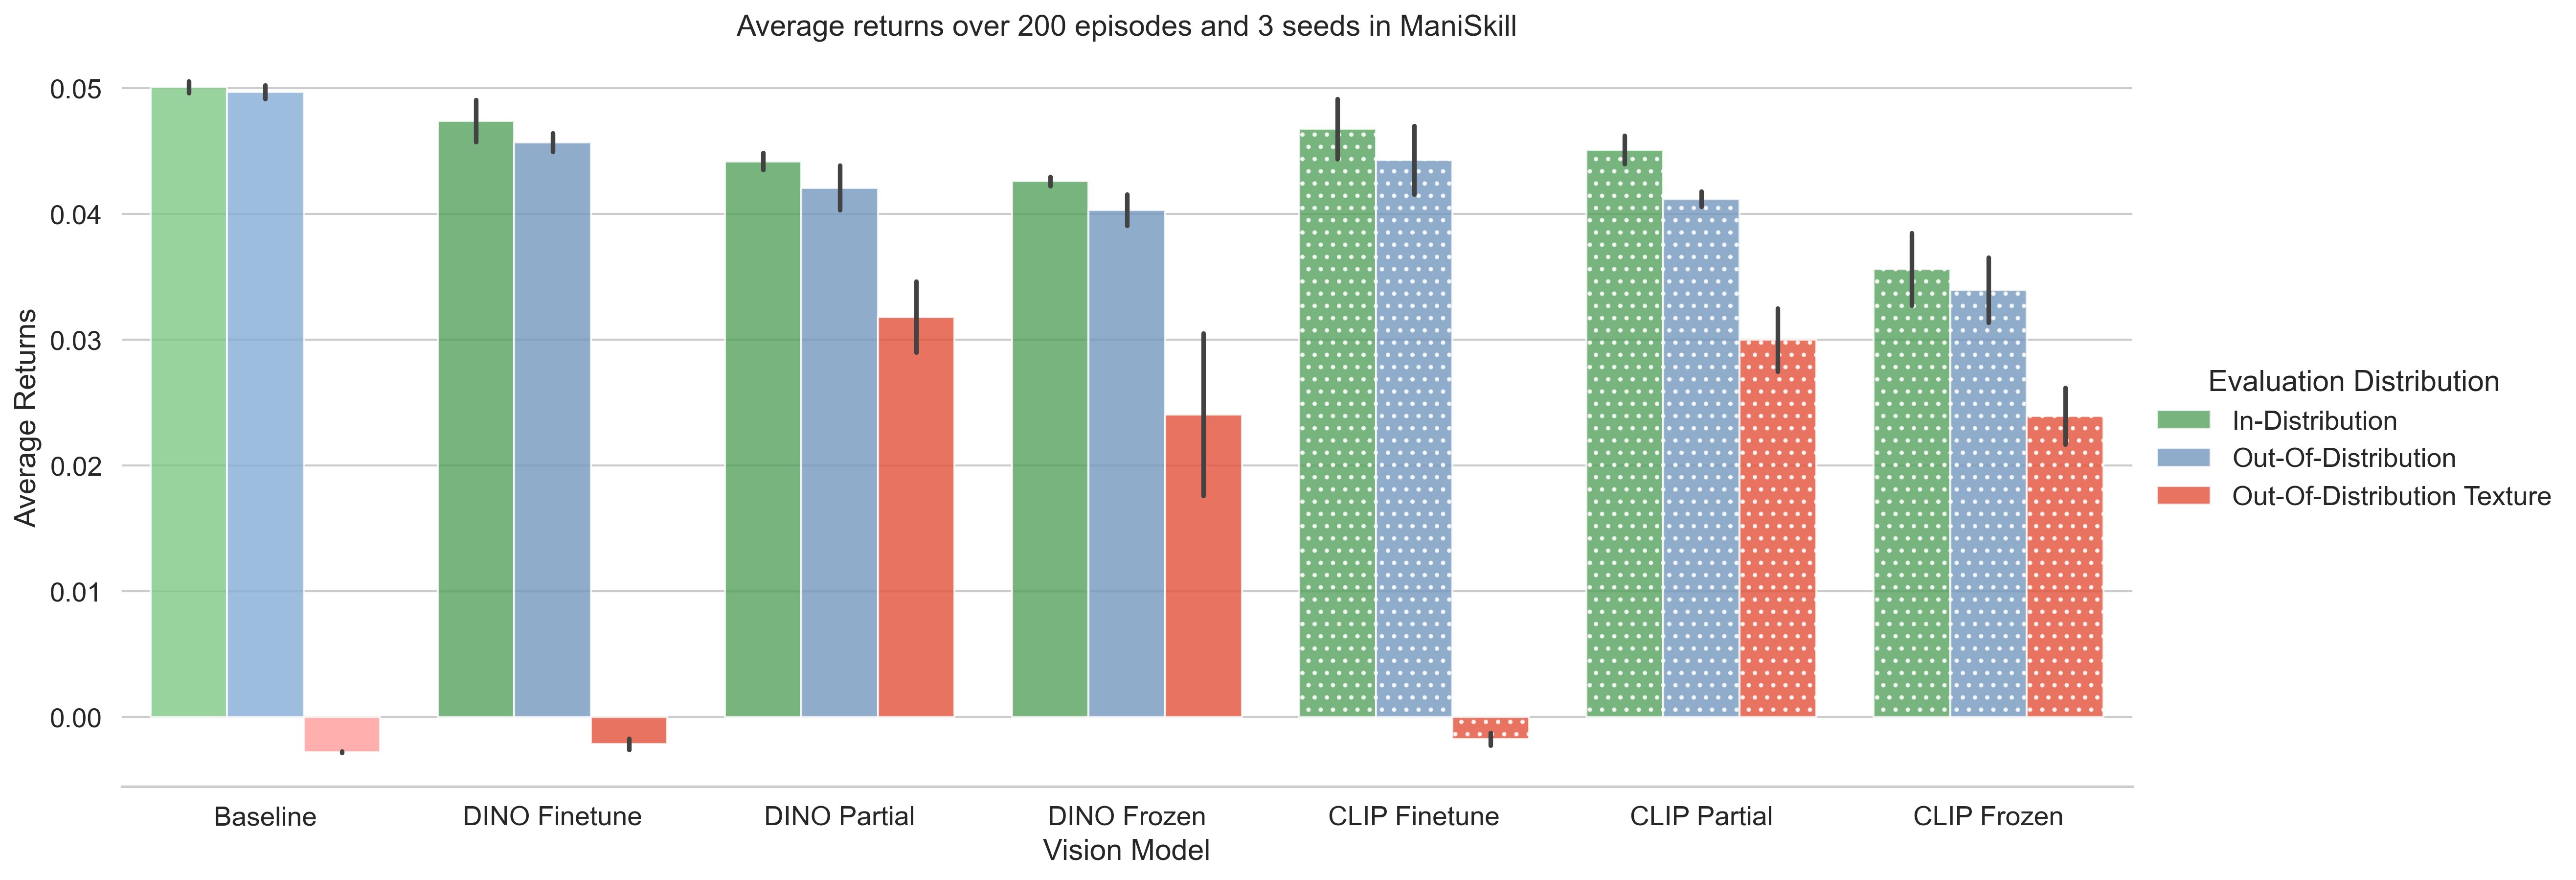

In [86]:
plot_maniskill(
    files_labels=[
        # ------- Baseline -------
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID/", "Baseline In-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_1/", "Baseline In-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_ID_2/", "Baseline In-Distribution"),
        
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD/", "Baseline Out-Of-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_1/", "Baseline Out-Of-Distribution"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_OOD_2/", "Baseline Out-Of-Distribution"),

        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood/", "Baseline Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_1/", "Baseline Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/BASELINE/baseline_pick_ycb_eval_dark_wood_2/", "Baseline Out-Of-Distribution_Texture"),

        # ------- DINO FT -------
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID/", "DINO Finetune In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_1/", "DINO Finetune In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_ID_2/", "DINO Finetune In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD/", "DINO Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_1/", "DINO Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_OOD_2/", "DINO Finetune Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood/", "DINO Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_1/", "DINO Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFT_pick_ycb_eval_dark_wood_2/", "DINO Finetune Out-Of-Distribution_Texture"),

        # ------- DINO Partial -------
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID/", "DINO Partial In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_1/", "DINO Partial In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_ID_2/", "DINO Partial In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD/", "DINO Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_1/", "DINO Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_OOD_2/", "DINO Partial Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood/", "DINO Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_1/", "DINO Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOPartial_pick_ycb_eval_dark_wood_2/", "DINO Partial Out-Of-Distribution_Texture"),

        # ------- DINO Frozen -------
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID/", "DINO Frozen In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_1/", "DINO Frozen In-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_ID_2/", "DINO Frozen In-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD/", "DINO Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_1/", "DINO Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_OOD_2/", "DINO Frozen Out-Of-Distribution"),

        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood/", "DINO Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_1/", "DINO Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/DINO/DINOFreeze_pick_ycb_eval_dark_wood_2/", "DINO Frozen Out-Of-Distribution_Texture"),

        # ------- CLIP FT -------
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID/", "CLIP Finetune In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID_1/", "CLIP Finetune In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_ID_2/", "CLIP Finetune In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD/", "CLIP Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD_1/", "CLIP Finetune Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_OOD_2/", "CLIP Finetune Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood/", "CLIP Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood_1/", "CLIP Finetune Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFT_pick_ycb_eval_dark_wood_2/", "CLIP Finetune Out-Of-Distribution_Texture"),

        # ------- CLIP Partial -------
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID/", "CLIP Partial In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID_1/", "CLIP Partial In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_ID_2/", "CLIP Partial In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD/", "CLIP Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD_1/", "CLIP Partial Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_OOD_2/", "CLIP Partial Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood/", "CLIP Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood_1/", "CLIP Partial Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPPartial_pick_ycb_eval_dark_wood_2/", "CLIP Partial Out-Of-Distribution_Texture"),

        # ------- CLIP Frozen -------
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID/", "CLIP Frozen In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID_1/", "CLIP Frozen In-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_ID_2/", "CLIP Frozen In-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD/", "CLIP Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD_1/", "CLIP Frozen Out-Of-Distribution"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_OOD_2/", "CLIP Frozen Out-Of-Distribution"),

        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood/", "CLIP Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood_1/", "CLIP Frozen Out-Of-Distribution_Texture"),
        ("logdir/PICK_YCB/CLIP/CLIPFreeze_pick_ycb_eval_dark_wood_2/", "CLIP Frozen Out-Of-Distribution_Texture"),
    ]
)

Random reward: -37.40520750709501
[{'reward': 0.147193678819967, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.15915449483946378, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.11971628857507659, 'model': 'Baseline', 'Evaluation Distribution': 'In-Distribution'}, {'reward': 0.03529185536659617, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.02808395517698343, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.038302776879896264, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.026883648161081655, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.020826490516009308, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward': 0.03827488967631226, 'model': 'Baseline', 'Evaluation Distribution': 'Out-Of-Distribution Weak'}, {'reward':

<Figure size 6000x1800 with 0 Axes>

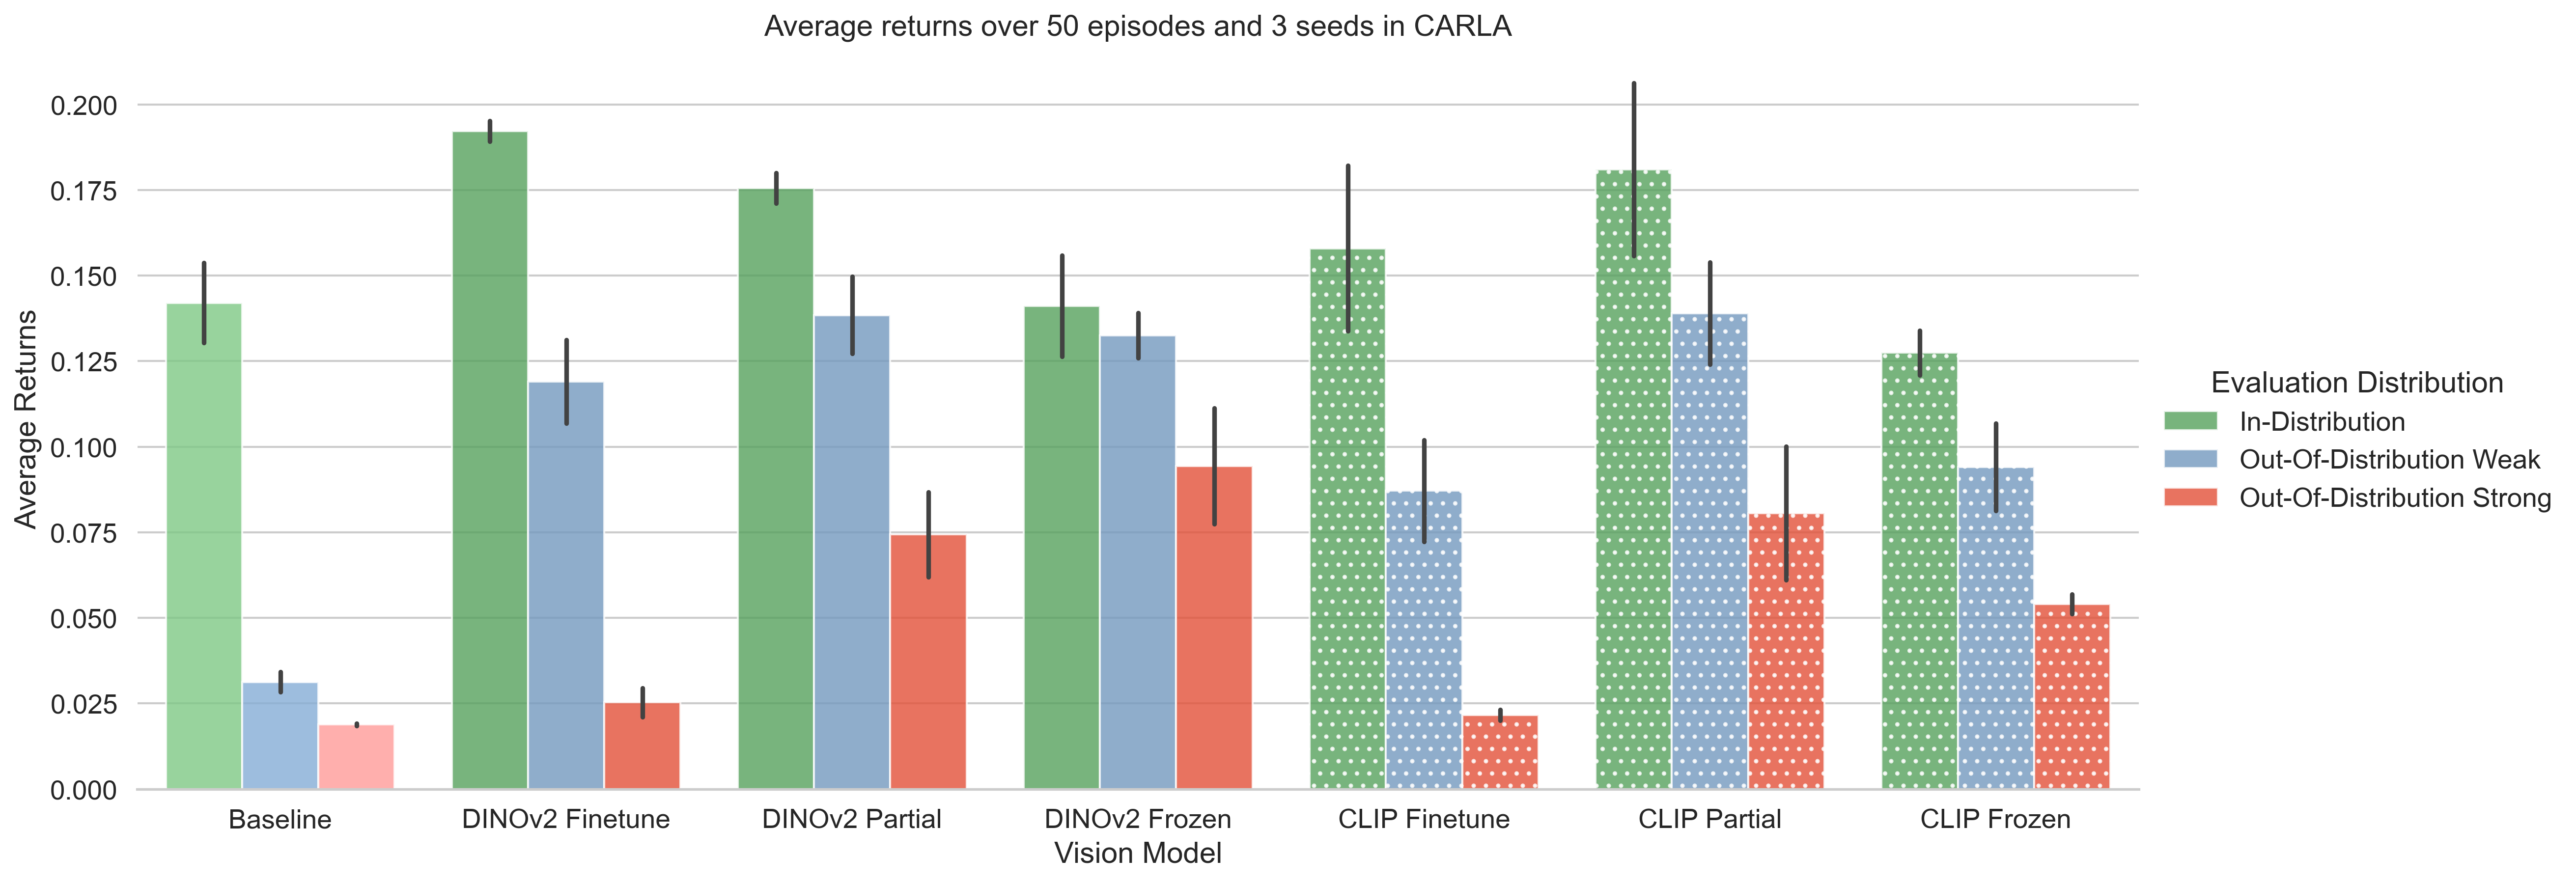

In [87]:
plot_carla(
    files_labels=[
        # ------- Baseline -------
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_1", "Baseline In-Distribution"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_ID_2", "Baseline In-Distribution"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_1", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_high_light_2", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_1", "Baseline Out-Of-Distribution_Weak"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_soft_noisy_low_light_2", "Baseline Out-Of-Distribution_Weak"),

        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_1", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_low_light_2", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_1", "Baseline Out-Of-Distribution_Strong"),
        ("logdir/CARLA/BASELINE/baseline_carla_eval_hard_noisy_low_light_2", "Baseline Out-Of-Distribution_Strong"),

        # ------- DINO FT -------
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_1", "DINOv2 Finetune In-Distribution"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_ID_2", "DINOv2 Finetune In-Distribution"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_1", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_high_light_2", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_soft_noisy_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_1", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFT_carla_eval_hard_noisy_low_light_2", "DINOv2 Finetune Out-Of-Distribution_Strong"),
        
        # ------- DINOv2 Partial -------
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_1", "DINOv2 Partial In-Distribution"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_ID_2", "DINOv2 Partial In-Distribution"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_1", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_high_light_2", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_1", "DINOv2 Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_soft_noisy_low_light_2", "DINOv2 Partial Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_1", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_low_light_2", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_1", "DINOv2 Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOPartial_carla_eval_hard_noisy_low_light_2", "DINOv2 Partial Out-Of-Distribution_Strong"),

        # ------- DINOv2 Frozen -------
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_1", "DINOv2 Frozen In-Distribution"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_ID_2", "DINOv2 Frozen In-Distribution"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_noisy_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_1", "DINOv2 Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_soft_high_light_2", "DINOv2 Frozen Out-Of-Distribution_Weak"),

        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_noisy_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_1", "DINOv2 Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/DINO/DINOFreeze_carla_eval_hard_low_light_2", "DINOv2 Frozen Out-Of-Distribution_Strong"),

        # ------- CLIP FT -------
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_1", "CLIP Finetune In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_ID_2", "CLIP Finetune In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_1", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_noisy_low_light_2", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_1", "CLIP Finetune Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_soft_high_light_2", "CLIP Finetune Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_1", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_noisy_low_light_2", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_1", "CLIP Finetune Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFT_carla_eval_hard_low_light_2", "CLIP Finetune Out-Of-Distribution_Strong"),

        # ------- CLIP Partial -------
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_1", "CLIP Partial In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_ID_2", "CLIP Partial In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_1", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_noisy_low_light_2", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_1", "CLIP Partial Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_soft_high_light_2", "CLIP Partial Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_1", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_noisy_low_light_2", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_1", "CLIP Partial Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPPartial_carla_eval_hard_low_light_2", "CLIP Partial Out-Of-Distribution_Strong"),

        # ------- CLIP Frozen -------
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_1", "CLIP Frozen In-Distribution"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_ID_2", "CLIP Frozen In-Distribution"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_1", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_noisy_low_light_2", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_1", "CLIP Frozen Out-Of-Distribution_Weak"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_soft_high_light_2", "CLIP Frozen Out-Of-Distribution_Weak"),

        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_1", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_noisy_low_light_2", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_1", "CLIP Frozen Out-Of-Distribution_Strong"),
        ("logdir/CARLA/CLIP/CLIPFreeze_carla_eval_hard_low_light_2", "CLIP Frozen Out-Of-Distribution_Strong"),
    ]
)

## Catastrophic Forgetting
In this experiment we train a K-Nearest Neighbours model on the output representation from the DinoV2 models before and after end-to-end finetuning with DreamerV3. In this small diagnostic test we trained using a 80:20 split from 20k ImageNet images.

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_56744/4048927896.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Catastrophic Forgetting: ImageNet KNN Accuracy'}, xlabel='Model Type', ylabel='Test Accuracy (%)'>

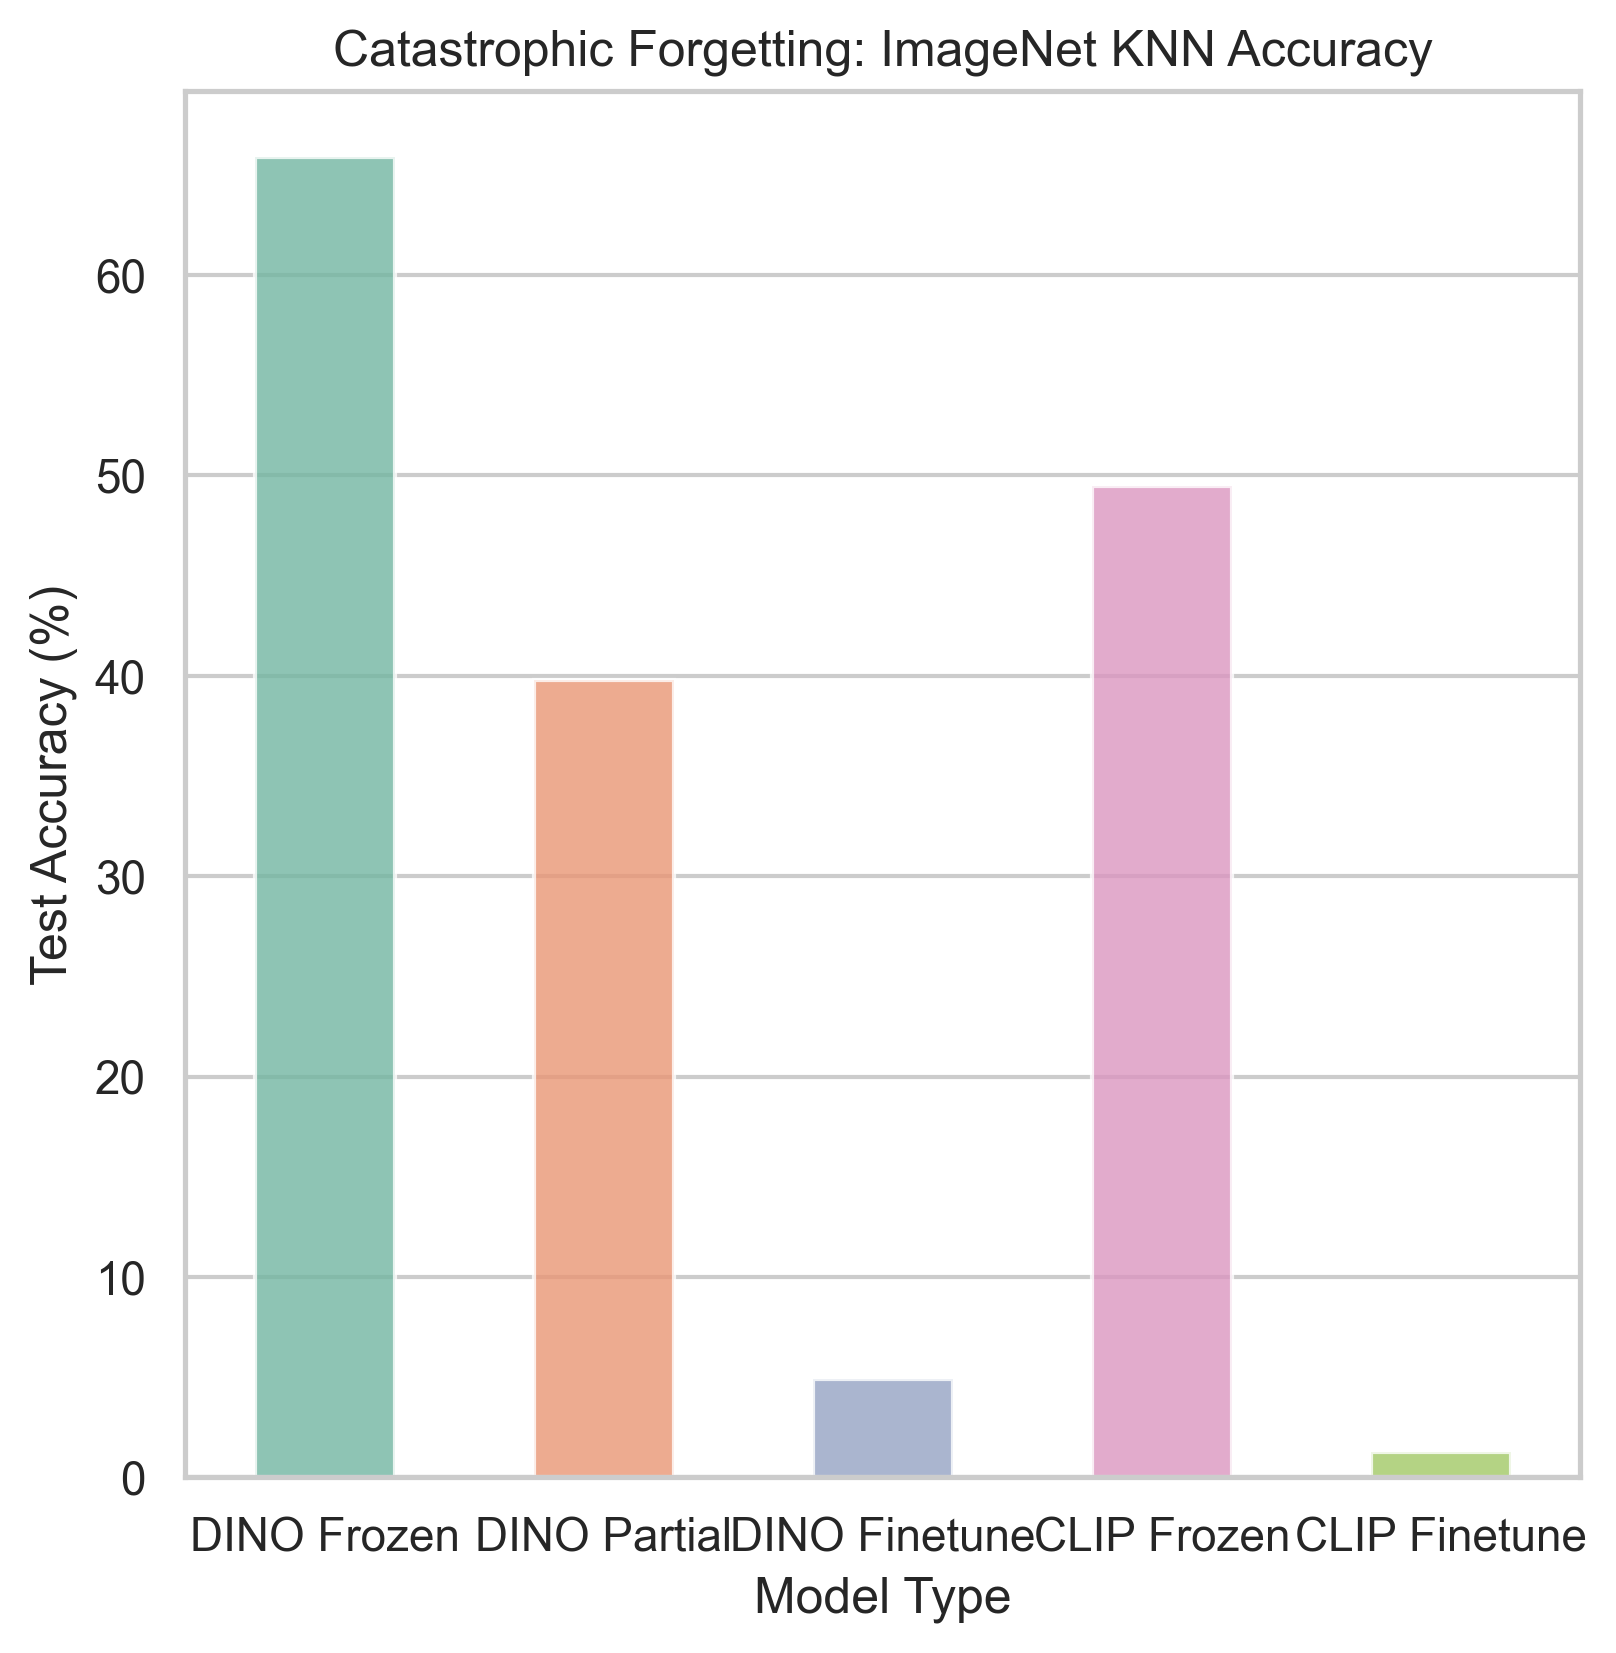

In [3]:
imagenet_knn_accuracy = [65.88, 39.77, 4.92, 49.45, 1.27]
imagenet_knn_labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Test Accuracy (%)")
plt.title(f"Catastrophic Forgetting: ImageNet KNN Accuracy")
sns.barplot(y=imagenet_knn_accuracy, x=imagenet_knn_labels, palette="Set2", width=0.5, alpha=0.8)

## Jaccard Index
With maniskill vision models

/var/folders/sz/_6t9n1rn6b7bxg8p0wzyw0g00000gn/T/ipykernel_56744/2129095480.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=jaccard_index, x=labels, palette="Set2", width=0.5, alpha=0.8)


<Axes: title={'center': 'Segmentation abiltity: Jaccard Index'}, xlabel='Model Type', ylabel='Jaccard Index(%)'>

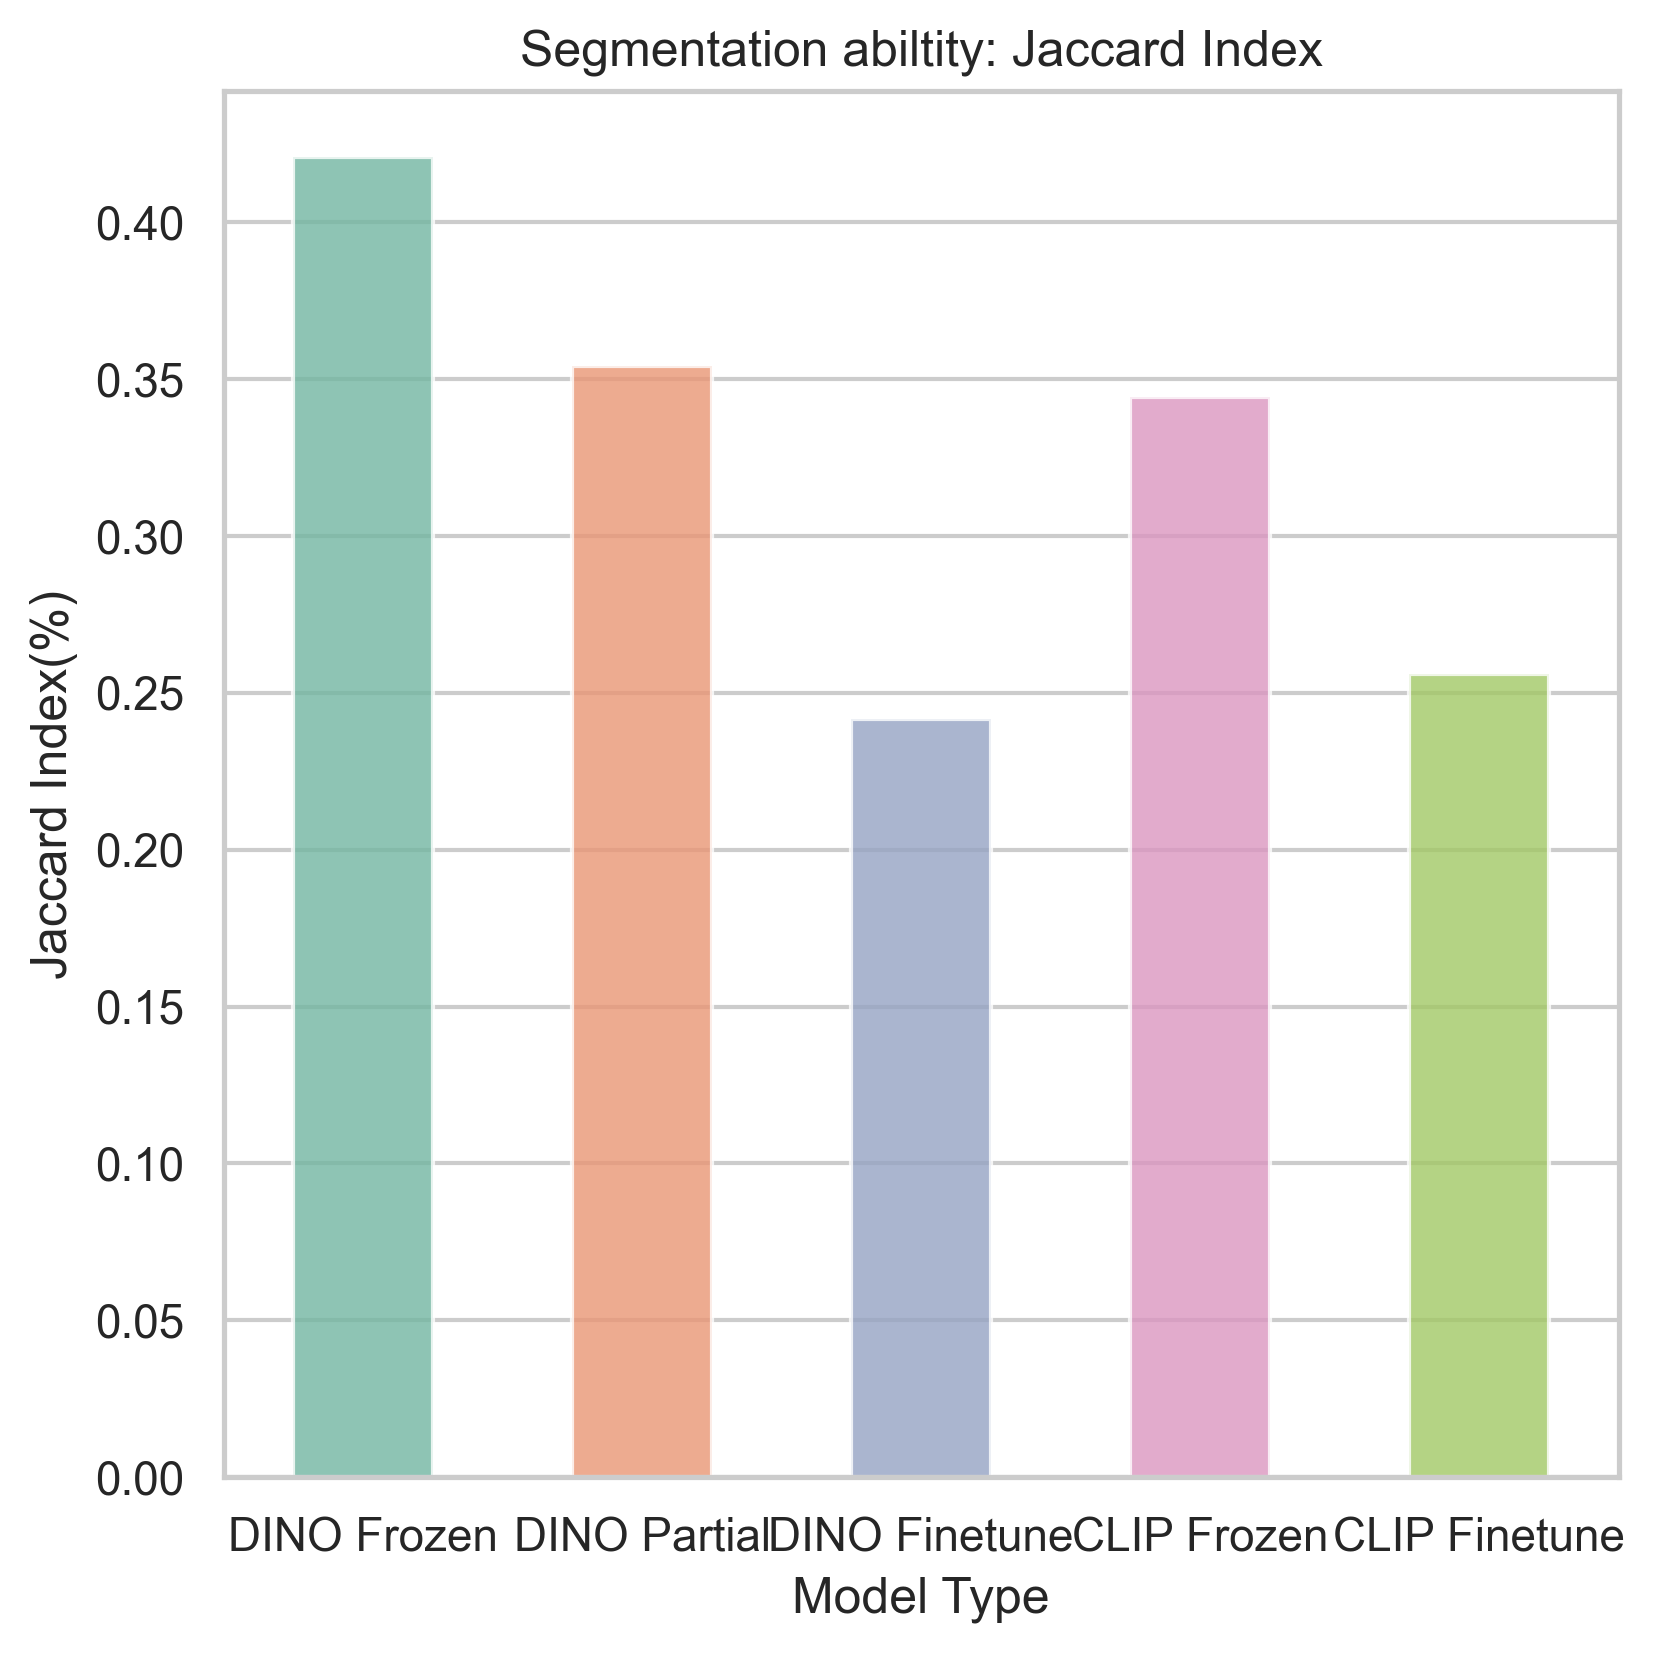

In [4]:
jaccard_index = [0.42062002258921743, 0.35423243885115097, 0.2416849635988227, 0.3443435035712217, 0.25605167583198163]
labels = ["DINO Frozen", "DINO Partial", "DINO Finetune", "CLIP Frozen", "CLIP Finetune"]
plt.figure(figsize=(6, 6))
plt.xlabel("Model Type")
plt.ylabel("Jaccard Index(%)")
plt.title(f"Segmentation abiltity: Jaccard Index")
sns.barplot(y=jaccard_index, x=labels, palette="Set2", width=0.5, alpha=0.8)